In [1]:
from __future__ import print_function, division
import os
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import torchvision
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import tqdm
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
from tensorflow.python.client import device_lib; device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2192419008901970679, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15255262765329108512
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7591234612920928305
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14254804173
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16086437351517530404
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [0]:
import tarfile
fname = 'data.tar.gz'
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [0]:
class DenoisingDataset(Dataset):

    def __init__(self, data_dir, transform=None, train=True):
        self.train= train 
        self.x_path = os.path.join(data_dir, 'distorted')
        self.y_path = os.path.join(data_dir, 'clean')
        self.x_test_path = os.path.join(data_dir, 'test_distorted')
        self.x_files_paths = glob.glob(os.path.join(self.x_path, '*.jpg'))
        self.y_files_paths = glob.glob(os.path.join(self.y_path, '*.jpg'))
        self.x_test_files_paths = glob.glob(os.path.join(self.x_test_path, '*.jpg'))
        self.transform = transform
        self.train_data = []
        self.test_data = []
        self.labels_data = []

    def __len__(self):
        if self.train:
            return len(self.x_files_paths)
        else:
            return len(self.x_test_files_paths)

    def __getitem__(self, idx):
        if self.train: 
            x_img_name, y_img_name =  self.x_files_paths[idx], self.y_files_paths[idx]
            x_image, y_image = io.imread(x_img_name), io.imread(y_img_name)
            x = self.transform(x_image)
            y = self.transform(y_image)
            self.train_data.append(x)
            self.labels_data.append(y)
            return x,y
            
        else:
            x_test_img_name =  self.x_test_files_paths[idx]
            x_test_image = io.imread(x_test_img_name)
            x = self.transform(x_test_image)
            self.test_data.append(x)
            return x
        
    def get_train_data(self, num):
        return torch.stack(self.train_data[:num]), torch.stack(self.labels_data[:num])
    def get_val_data(self, num):
        return torch.stack(self.val_data[:num]), torch.stack(self.val_labels_data[:num])
    
    def get_test_data(self, num):
        return torch.stack(self.test_data[:num])

In [4]:
# Hyper Parameters
epochs = 14
lr = 0.005
n_plots = 1
batch_size = 32
torch.manual_seed(42)

In [0]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
      
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 32, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 32, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            
            
            nn.Conv2d(32, 32, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 32, (3, 3), padding=1),
            
            nn.ReLU(inplace=True),
            
            
            
            
        )
        self.out = nn.Sigmoid()

        self.decoder = nn.Sequential(
            nn.Conv2d(32, 32, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 32, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 32, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 32, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            
           
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(32, 3, (3, 3), padding=1),
           
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = self.out(decoded)
        
        return encoded, decoded


torch.Size([32, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0275, 0.0275, 0.0275],
         [0.0000, 0.0000, 0.0000,  ..., 0.0235, 0.0235, 0.0235],
         [0.0000, 0.0000, 0.0000,  ..., 0.1059, 0.1098, 0.1137],
         ...,
         [0.0275, 0.0275, 0.0275,  ..., 0.0157, 0.0157, 0.0157],
         [0.0902, 0.0863, 0.0863,  ..., 0.0392, 0.0392, 0.0392],
         [0.0275, 0.0275, 0.0275,  ..., 0.0431, 0.0431, 0.0431]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0118, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0118, 0.0118,  ..., 0.0784, 0.0824, 0.0863],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0588, 0.0549, 0.0549,  ..., 0.0157, 0.0157, 0.0157],
         [0.0235, 0.0235, 0.0235,  ..., 0.0157, 0.0157, 0.0157]],

        [[0.0784, 0.0784, 0.0784,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0078, 0.0078, 0.0078],
         [0.0353, 0.0353, 0.03

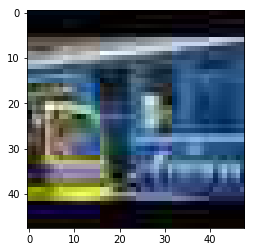

tensor([[[0.0157, 0.0118, 0.0000,  ..., 0.0000, 0.0275, 0.0431],
         [0.0118, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0157],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
         ...,
         [0.0275, 0.0118, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0196, 0.0039,  ..., 0.0000, 0.0039, 0.0118],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0157, 0.0314]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0000, 0.0000],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0196, 0.0196],
         ...,
         [0.0118, 0.0078, 0.0118,  ..., 0.0039, 0.0078, 0.0039],
         [0.0000, 0.0157, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0196, 0.0275, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0078, 0.

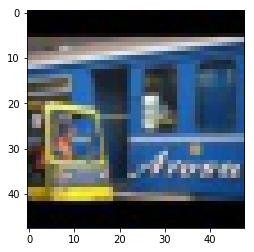

In [13]:
train_dataset = DenoisingDataset('data', 
                                 transform=transforms.Compose([
                                     torchvision.transforms.ToTensor(),
                                ]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
print(next(iter(train_loader))[0].shape)

def show_img(image):
    print(image)
    plt.imshow(image.permute(1, 2, 0).type(torch.FloatTensor)  )
    plt.pause(0.001)  # pause a bit so that plots are updated
    
show_img(train_dataset.get_train_data(5)[0][3])
show_img(train_dataset.get_train_data(5)[1][3])




0it [00:00, ?it/s]

Epoch:  0 | train loss: 0.0676
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


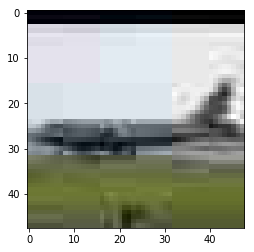

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

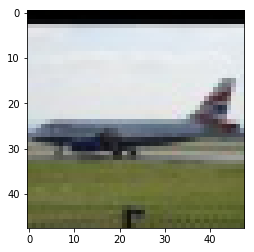

tensor([[[0.5307, 0.5234, 0.5240,  ..., 0.5247, 0.5237, 0.5176],
         [0.5415, 0.5218, 0.5208,  ..., 0.5213, 0.5199, 0.5146],
         [0.5419, 0.5189, 0.5170,  ..., 0.5163, 0.5150, 0.5118],
         ...,
         [0.5373, 0.5115, 0.5081,  ..., 0.5048, 0.5055, 0.5073],
         [0.5345, 0.5095, 0.5058,  ..., 0.5025, 0.5049, 0.5081],
         [0.5232, 0.5073, 0.5046,  ..., 0.5018, 0.5030, 0.5062]],

        [[0.5200, 0.5104, 0.5097,  ..., 0.5120, 0.5139, 0.5246],
         [0.5095, 0.4938, 0.4914,  ..., 0.4966, 0.5001, 0.5199],
         [0.5076, 0.4881, 0.4846,  ..., 0.4897, 0.4941, 0.5159],
         ...,
         [0.5077, 0.4857, 0.4812,  ..., 0.4827, 0.4872, 0.5100],
         [0.5101, 0.4904, 0.4864,  ..., 0.4867, 0.4902, 0.5117],
         [0.5098, 0.4938, 0.4904,  ..., 0.4893, 0.4922, 0.5065]],

        [[0.4782, 0.4591, 0.4564,  ..., 0.4542, 0.4549, 0.4585],
         [0.4691, 0.4508, 0.4475,  ..., 0.4451, 0.4472, 0.4587],
         [0.4658, 0.4465, 0.4433,  ..., 0.4406, 0.4439, 0.

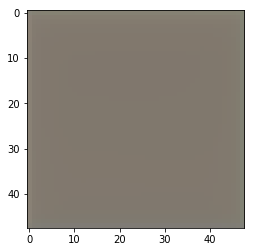




1it [00:00,  1.16it/s]


2it [00:01,  1.43it/s]


3it [00:01,  1.70it/s]


4it [00:01,  1.99it/s]


5it [00:02,  2.26it/s]


6it [00:02,  2.49it/s]


7it [00:02,  2.64it/s]


8it [00:03,  2.81it/s]


9it [00:03,  2.92it/s]


10it [00:03,  2.94it/s]


11it [00:04,  3.01it/s]


12it [00:04,  3.06it/s]


13it [00:04,  3.09it/s]


14it [00:04,  3.15it/s]


15it [00:05,  3.16it/s]


16it [00:05,  3.18it/s]


17it [00:05,  3.13it/s]


18it [00:06,  3.16it/s]


19it [00:06,  3.17it/s]


20it [00:06,  3.17it/s]


21it [00:07,  3.16it/s]


22it [00:07,  3.14it/s]


23it [00:07,  3.15it/s]


24it [00:08,  3.20it/s]


25it [00:08,  3.21it/s]


26it [00:08,  3.21it/s]


27it [00:09,  3.22it/s]


28it [00:09,  3.25it/s]


29it [00:09,  3.29it/s]


30it [00:09,  3.26it/s]


31it [00:10,  3.27it/s]


32it [00:10,  3.28it/s]


33it [00:10,  3.17it/s]


34it [00:11,  3.22it/s]


35it [00:11,  3.24it/s]


36it [00:11,  3.25it/s]


37it [00:12,  3.23it/s]


38it [00:12,  3.26it/s]


39it [00:12,  3.27

Epoch:  0 | train loss: 0.0120
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


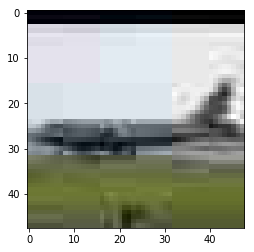

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

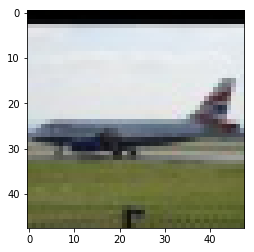

tensor([[[0.1710, 0.0584, 0.0292,  ..., 0.0189, 0.0363, 0.1171],
         [0.1255, 0.0480, 0.0244,  ..., 0.0153, 0.0305, 0.1366],
         [0.2739, 0.1926, 0.1537,  ..., 0.0992, 0.1248, 0.2495],
         ...,
         [0.4149, 0.3361, 0.3193,  ..., 0.2670, 0.2814, 0.3696],
         [0.4206, 0.3456, 0.3278,  ..., 0.2798, 0.2955, 0.3826],
         [0.4370, 0.3786, 0.3637,  ..., 0.3289, 0.3443, 0.4082]],

        [[0.1674, 0.0426, 0.0192,  ..., 0.0109, 0.0216, 0.0919],
         [0.1388, 0.0481, 0.0236,  ..., 0.0115, 0.0195, 0.0913],
         [0.3012, 0.2105, 0.1724,  ..., 0.0982, 0.1070, 0.2344],
         ...,
         [0.3780, 0.3045, 0.2884,  ..., 0.2447, 0.2481, 0.3416],
         [0.3840, 0.3124, 0.2952,  ..., 0.2531, 0.2608, 0.3573],
         [0.4068, 0.3583, 0.3426,  ..., 0.3107, 0.3182, 0.3924]],

        [[0.2192, 0.0733, 0.0412,  ..., 0.0241, 0.0358, 0.0954],
         [0.1301, 0.0597, 0.0336,  ..., 0.0197, 0.0304, 0.1230],
         [0.2136, 0.2052, 0.1745,  ..., 0.1281, 0.1438, 0.

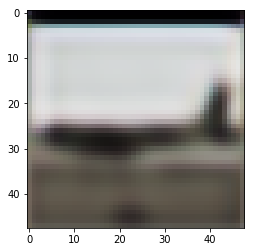




101it [00:32,  2.11it/s]


102it [00:32,  2.33it/s]


103it [00:33,  2.58it/s]


104it [00:33,  2.76it/s]


105it [00:33,  2.88it/s]


106it [00:33,  2.96it/s]


107it [00:34,  3.06it/s]


108it [00:34,  3.11it/s]


109it [00:34,  3.16it/s]


110it [00:35,  3.18it/s]


111it [00:35,  3.22it/s]


112it [00:35,  3.22it/s]


113it [00:36,  3.27it/s]


114it [00:36,  3.24it/s]


115it [00:36,  3.22it/s]


116it [00:37,  3.26it/s]


117it [00:37,  3.29it/s]


118it [00:37,  3.24it/s]


119it [00:37,  3.25it/s]


120it [00:38,  3.28it/s]


121it [00:38,  3.28it/s]


122it [00:38,  3.23it/s]


123it [00:39,  3.27it/s]


124it [00:39,  3.29it/s]


125it [00:39,  3.26it/s]


126it [00:40,  3.29it/s]


127it [00:40,  3.32it/s]


128it [00:40,  3.29it/s]


129it [00:41,  3.26it/s]


130it [00:41,  3.30it/s]


131it [00:41,  3.33it/s]


132it [00:41,  3.31it/s]


133it [00:42,  3.25it/s]


134it [00:42,  3.28it/s]


135it [00:42,  3.28it/s]


136it [00:43,  3.28it/s]


137it [00:43,  3.30it/s]


Epoch:  0 | train loss: 0.0079
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


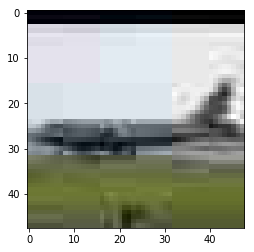

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

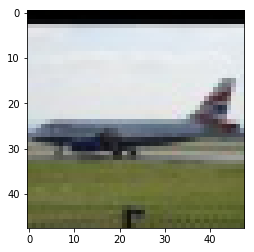

tensor([[[0.0214, 0.0032, 0.0009,  ..., 0.0007, 0.0020, 0.0229],
         [0.0220, 0.0048, 0.0016,  ..., 0.0013, 0.0032, 0.0459],
         [0.1698, 0.1099, 0.0759,  ..., 0.0710, 0.0944, 0.2342],
         ...,
         [0.3943, 0.3602, 0.3599,  ..., 0.3644, 0.3571, 0.3979],
         [0.3847, 0.3435, 0.3395,  ..., 0.3148, 0.3141, 0.3738],
         [0.4047, 0.3592, 0.3511,  ..., 0.3065, 0.3181, 0.3775]],

        [[0.0530, 0.0043, 0.0011,  ..., 0.0011, 0.0031, 0.0369],
         [0.0386, 0.0063, 0.0016,  ..., 0.0014, 0.0035, 0.0588],
         [0.2464, 0.1540, 0.0802,  ..., 0.0676, 0.0858, 0.2779],
         ...,
         [0.3938, 0.3652, 0.3656,  ..., 0.3594, 0.3470, 0.3951],
         [0.3858, 0.3479, 0.3410,  ..., 0.3014, 0.2968, 0.3649],
         [0.3916, 0.3620, 0.3491,  ..., 0.3009, 0.3016, 0.3688]],

        [[0.0413, 0.0037, 0.0012,  ..., 0.0007, 0.0021, 0.0223],
         [0.0300, 0.0073, 0.0025,  ..., 0.0029, 0.0072, 0.0839],
         [0.1683, 0.1588, 0.0994,  ..., 0.1189, 0.1421, 0.

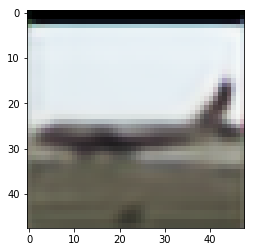




201it [01:03,  2.12it/s]


202it [01:04,  2.35it/s]


203it [01:04,  2.55it/s]


204it [01:04,  2.74it/s]


205it [01:04,  2.87it/s]


206it [01:05,  3.00it/s]


207it [01:05,  3.05it/s]


208it [01:05,  3.09it/s]


209it [01:06,  3.13it/s]


210it [01:06,  3.14it/s]


211it [01:06,  3.16it/s]


212it [01:07,  3.23it/s]


213it [01:07,  3.27it/s]


214it [01:07,  3.23it/s]


215it [01:08,  3.26it/s]


216it [01:08,  3.25it/s]


217it [01:08,  3.22it/s]


218it [01:08,  3.26it/s]


219it [01:09,  3.27it/s]


220it [01:09,  3.26it/s]


221it [01:09,  3.26it/s]


222it [01:10,  3.28it/s]


223it [01:10,  3.31it/s]


224it [01:10,  3.28it/s]


225it [01:11,  3.30it/s]


226it [01:11,  3.30it/s]


227it [01:11,  3.26it/s]


228it [01:12,  3.30it/s]


229it [01:12,  3.31it/s]


230it [01:12,  3.31it/s]


231it [01:12,  3.28it/s]


232it [01:13,  3.28it/s]


233it [01:13,  3.25it/s]


234it [01:13,  3.20it/s]


235it [01:14,  3.22it/s]


236it [01:14,  3.24it/s]


237it [01:14,  3.23it/s]


Epoch:  0 | train loss: 0.0086
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


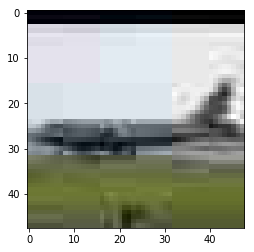

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

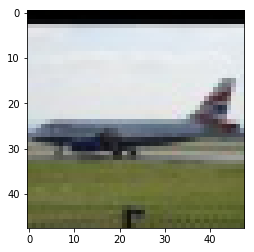

tensor([[[1.3522e-02, 1.6387e-03, 4.4531e-04,  ..., 2.3483e-04,
          8.5798e-04, 1.2217e-02],
         [1.9396e-02, 3.2988e-03, 1.1633e-03,  ..., 6.7301e-04,
          1.8908e-03, 3.6249e-02],
         [1.4968e-01, 9.3348e-02, 6.4468e-02,  ..., 6.1631e-02,
          8.7104e-02, 2.7039e-01],
         ...,
         [3.7151e-01, 3.4451e-01, 3.6636e-01,  ..., 3.7688e-01,
          3.1847e-01, 3.2972e-01],
         [3.5091e-01, 3.1116e-01, 3.1832e-01,  ..., 2.9902e-01,
          2.6336e-01, 3.0381e-01],
         [3.7458e-01, 3.2153e-01, 3.1199e-01,  ..., 2.6412e-01,
          2.6553e-01, 3.2264e-01]],

        [[3.2701e-02, 2.5314e-03, 6.3005e-04,  ..., 3.5438e-04,
          1.2615e-03, 2.1009e-02],
         [2.1466e-02, 3.1186e-03, 6.8199e-04,  ..., 4.7179e-04,
          1.4143e-03, 3.7928e-02],
         [1.7434e-01, 8.1975e-02, 3.4273e-02,  ..., 3.4451e-02,
          5.2720e-02, 2.4153e-01],
         ...,
         [3.6312e-01, 3.4008e-01, 3.5669e-01,  ..., 3.5293e-01,
          2.924

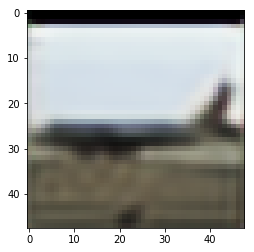




301it [01:35,  2.07it/s]


302it [01:35,  2.29it/s]


303it [01:35,  2.51it/s]


304it [01:36,  2.72it/s]


305it [01:36,  2.87it/s]


306it [01:36,  2.97it/s]


307it [01:36,  3.06it/s]


308it [01:37,  3.14it/s]


309it [01:37,  3.17it/s]


310it [01:37,  3.24it/s]


311it [01:38,  3.27it/s]


312it [01:38,  3.25it/s]


313it [01:38,  3.84it/s]





0it [00:00, ?it/s]

Epoch:  1 | train loss: 0.0127
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


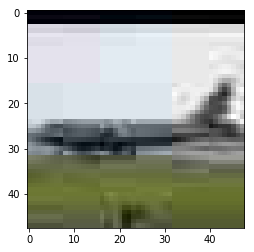

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

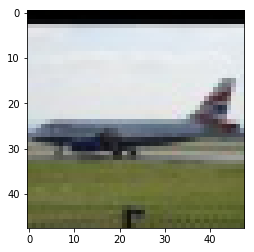

tensor([[[0.0421, 0.0090, 0.0036,  ..., 0.0037, 0.0076, 0.0417],
         [0.0472, 0.0116, 0.0051,  ..., 0.0050, 0.0088, 0.0643],
         [0.1984, 0.1321, 0.0931,  ..., 0.0918, 0.1100, 0.2465],
         ...,
         [0.4099, 0.3787, 0.3840,  ..., 0.3770, 0.3600, 0.3852],
         [0.3908, 0.3500, 0.3459,  ..., 0.3220, 0.3151, 0.3595],
         [0.4016, 0.3540, 0.3440,  ..., 0.3092, 0.3183, 0.3687]],

        [[0.0956, 0.0172, 0.0067,  ..., 0.0068, 0.0128, 0.0691],
         [0.0721, 0.0186, 0.0059,  ..., 0.0066, 0.0106, 0.0861],
         [0.2915, 0.1644, 0.0808,  ..., 0.0830, 0.0940, 0.2923],
         ...,
         [0.4142, 0.3971, 0.4006,  ..., 0.3885, 0.3711, 0.4023],
         [0.4028, 0.3709, 0.3639,  ..., 0.3343, 0.3240, 0.3746],
         [0.3966, 0.3664, 0.3532,  ..., 0.3145, 0.3141, 0.3723]],

        [[0.0793, 0.0123, 0.0055,  ..., 0.0046, 0.0088, 0.0495],
         [0.0743, 0.0206, 0.0091,  ..., 0.0107, 0.0176, 0.1226],
         [0.2422, 0.1602, 0.1007,  ..., 0.1295, 0.1360, 0.

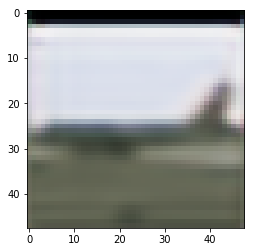




1it [00:00,  1.13it/s]


2it [00:01,  1.40it/s]


3it [00:01,  1.68it/s]


4it [00:01,  1.98it/s]


5it [00:02,  2.24it/s]


6it [00:02,  2.47it/s]


7it [00:02,  2.67it/s]


8it [00:03,  2.83it/s]


9it [00:03,  2.94it/s]


10it [00:03,  3.05it/s]


11it [00:03,  3.10it/s]


12it [00:04,  3.18it/s]


13it [00:04,  3.20it/s]


14it [00:04,  3.26it/s]


15it [00:05,  3.26it/s]


16it [00:05,  3.28it/s]


17it [00:05,  3.29it/s]


18it [00:06,  3.29it/s]


19it [00:06,  3.25it/s]


20it [00:06,  3.26it/s]


21it [00:06,  3.29it/s]


22it [00:07,  3.27it/s]


23it [00:07,  3.26it/s]


24it [00:07,  3.28it/s]


25it [00:08,  3.27it/s]


26it [00:08,  3.29it/s]


27it [00:08,  3.30it/s]


28it [00:09,  3.26it/s]


29it [00:09,  3.29it/s]


30it [00:09,  3.27it/s]


31it [00:10,  3.30it/s]


32it [00:10,  3.26it/s]


33it [00:10,  3.27it/s]


34it [00:10,  3.29it/s]


35it [00:11,  3.24it/s]


36it [00:11,  3.27it/s]


37it [00:11,  3.28it/s]


38it [00:12,  3.26it/s]


39it [00:12,  3.28

Epoch:  1 | train loss: 0.0065
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


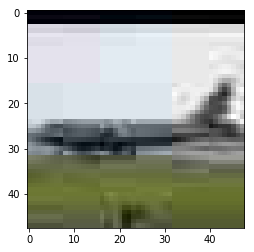

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

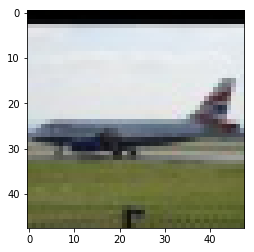

tensor([[[0.0354, 0.0056, 0.0015,  ..., 0.0013, 0.0031, 0.0227],
         [0.0603, 0.0093, 0.0026,  ..., 0.0028, 0.0053, 0.0491],
         [0.2335, 0.1430, 0.0806,  ..., 0.0837, 0.1027, 0.2467],
         ...,
         [0.4042, 0.3721, 0.3702,  ..., 0.3762, 0.3560, 0.3701],
         [0.3835, 0.3440, 0.3362,  ..., 0.3296, 0.3181, 0.3500],
         [0.3906, 0.3433, 0.3333,  ..., 0.3326, 0.3358, 0.3686]],

        [[0.0764, 0.0089, 0.0023,  ..., 0.0018, 0.0040, 0.0393],
         [0.0570, 0.0087, 0.0016,  ..., 0.0022, 0.0040, 0.0579],
         [0.2652, 0.1158, 0.0419,  ..., 0.0472, 0.0593, 0.2584],
         ...,
         [0.4131, 0.3942, 0.3836,  ..., 0.3784, 0.3579, 0.3855],
         [0.4040, 0.3723, 0.3551,  ..., 0.3341, 0.3227, 0.3662],
         [0.3895, 0.3547, 0.3359,  ..., 0.3242, 0.3185, 0.3679]],

        [[0.0559, 0.0046, 0.0015,  ..., 0.0008, 0.0019, 0.0207],
         [0.0742, 0.0089, 0.0025,  ..., 0.0025, 0.0050, 0.0604],
         [0.3043, 0.1243, 0.0623,  ..., 0.0968, 0.1093, 0.

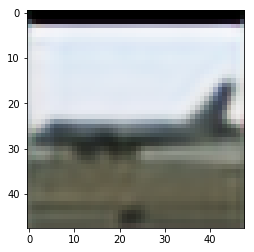




101it [00:32,  1.74it/s]


102it [00:32,  2.03it/s]


103it [00:32,  2.31it/s]


104it [00:32,  2.54it/s]


105it [00:33,  2.74it/s]


106it [00:33,  2.90it/s]


107it [00:33,  2.98it/s]


108it [00:34,  3.07it/s]


109it [00:34,  3.14it/s]


110it [00:34,  3.20it/s]


111it [00:35,  3.24it/s]


112it [00:35,  3.30it/s]


113it [00:35,  3.32it/s]


114it [00:36,  3.30it/s]


115it [00:36,  3.33it/s]


116it [00:36,  3.34it/s]


117it [00:36,  3.34it/s]


118it [00:37,  3.34it/s]


119it [00:37,  3.34it/s]


120it [00:37,  3.33it/s]


121it [00:38,  3.23it/s]


122it [00:38,  3.27it/s]


123it [00:38,  3.32it/s]


124it [00:39,  3.30it/s]


125it [00:39,  3.33it/s]


126it [00:39,  3.34it/s]


127it [00:39,  3.35it/s]


128it [00:40,  3.31it/s]


129it [00:40,  3.32it/s]


130it [00:40,  3.34it/s]


131it [00:41,  3.31it/s]


132it [00:41,  3.35it/s]


133it [00:41,  3.35it/s]


134it [00:42,  3.34it/s]


135it [00:42,  3.34it/s]


136it [00:42,  3.35it/s]


137it [00:42,  3.36it/s]


Epoch:  1 | train loss: 0.0060
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


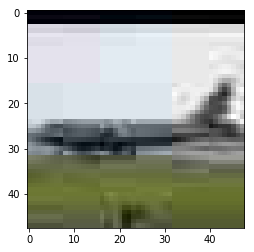

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

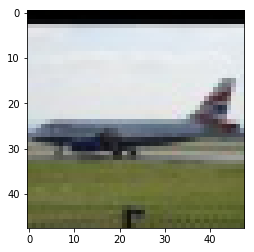

tensor([[[1.7444e-02, 1.8884e-03, 4.1936e-04,  ..., 1.6470e-04,
          5.4040e-04, 7.6617e-03],
         [3.9850e-02, 5.5429e-03, 1.5539e-03,  ..., 7.5284e-04,
          1.5929e-03, 2.4168e-02],
         [2.9004e-01, 2.0227e-01, 1.2199e-01,  ..., 8.4956e-02,
          9.4446e-02, 2.2133e-01],
         ...,
         [3.9922e-01, 3.8087e-01, 3.9257e-01,  ..., 3.8219e-01,
          3.5535e-01, 3.6640e-01],
         [3.8115e-01, 3.5339e-01, 3.5438e-01,  ..., 3.3261e-01,
          3.1816e-01, 3.4800e-01],
         [3.9306e-01, 3.5233e-01, 3.4740e-01,  ..., 3.3518e-01,
          3.3710e-01, 3.6681e-01]],

        [[4.0006e-02, 3.4997e-03, 8.9225e-04,  ..., 3.0552e-04,
          8.7554e-04, 1.7231e-02],
         [3.7323e-02, 7.1234e-03, 1.5031e-03,  ..., 9.7736e-04,
          1.8005e-03, 3.8108e-02],
         [3.0693e-01, 2.2475e-01, 1.0185e-01,  ..., 7.9711e-02,
          8.0465e-02, 2.5947e-01],
         ...,
         [3.9289e-01, 3.8545e-01, 3.8333e-01,  ..., 3.6336e-01,
          3.430

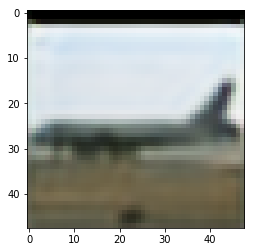




201it [01:03,  2.07it/s]


202it [01:03,  2.28it/s]


203it [01:04,  2.48it/s]


204it [01:04,  2.65it/s]


205it [01:04,  2.78it/s]


206it [01:04,  2.87it/s]


207it [01:05,  2.97it/s]


208it [01:05,  3.01it/s]


209it [01:05,  3.02it/s]


210it [01:06,  3.06it/s]


211it [01:06,  3.08it/s]


212it [01:06,  3.09it/s]


213it [01:07,  3.12it/s]


214it [01:07,  3.12it/s]


215it [01:07,  3.10it/s]


216it [01:08,  3.10it/s]


217it [01:08,  3.13it/s]


218it [01:08,  3.14it/s]


219it [01:09,  3.11it/s]


220it [01:09,  3.05it/s]


221it [01:09,  3.08it/s]


222it [01:10,  3.06it/s]


223it [01:10,  3.11it/s]


224it [01:10,  3.15it/s]


225it [01:11,  3.15it/s]


226it [01:11,  3.16it/s]


227it [01:11,  3.16it/s]


228it [01:12,  3.09it/s]


229it [01:12,  3.07it/s]


230it [01:12,  3.10it/s]


231it [01:13,  3.08it/s]


232it [01:13,  3.11it/s]


233it [01:13,  3.14it/s]


234it [01:13,  3.11it/s]


235it [01:14,  3.05it/s]


236it [01:14,  3.09it/s]


237it [01:14,  3.11it/s]


Epoch:  1 | train loss: 0.0056
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


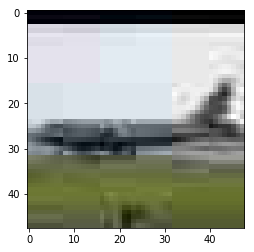

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

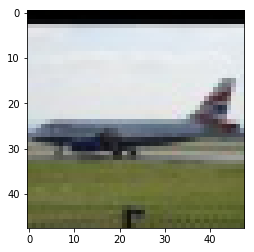

tensor([[[7.4288e-03, 5.3650e-04, 9.3825e-05,  ..., 2.6294e-05,
          1.4158e-04, 3.3609e-03],
         [2.0119e-02, 2.0404e-03, 5.1602e-04,  ..., 1.5609e-04,
          4.9946e-04, 1.1186e-02],
         [2.0514e-01, 1.2395e-01, 7.3686e-02,  ..., 3.4404e-02,
          4.5111e-02, 1.2947e-01],
         ...,
         [4.0168e-01, 3.8472e-01, 3.9652e-01,  ..., 3.7456e-01,
          3.4736e-01, 3.5993e-01],
         [3.7458e-01, 3.4501e-01, 3.4479e-01,  ..., 3.2376e-01,
          3.1320e-01, 3.4421e-01],
         [3.7763e-01, 3.3063e-01, 3.2485e-01,  ..., 3.1696e-01,
          3.2110e-01, 3.5027e-01]],

        [[1.7625e-02, 9.1330e-04, 2.0234e-04,  ..., 6.4556e-05,
          2.6895e-04, 7.6874e-03],
         [1.6834e-02, 2.4896e-03, 5.2174e-04,  ..., 2.6608e-04,
          6.8331e-04, 1.7933e-02],
         [1.9447e-01, 1.2791e-01, 6.2809e-02,  ..., 3.5931e-02,
          4.2407e-02, 1.5373e-01],
         ...,
         [3.8507e-01, 3.6952e-01, 3.6324e-01,  ..., 3.4878e-01,
          3.197

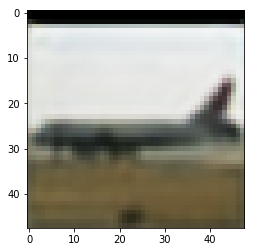




301it [01:36,  2.06it/s]


302it [01:36,  2.29it/s]


303it [01:36,  2.48it/s]


304it [01:37,  2.66it/s]


305it [01:37,  2.78it/s]


306it [01:37,  2.87it/s]


307it [01:37,  2.92it/s]


308it [01:38,  2.96it/s]


309it [01:38,  3.04it/s]


310it [01:38,  3.01it/s]


311it [01:39,  3.05it/s]


312it [01:39,  3.08it/s]


313it [01:39,  3.63it/s]





0it [00:00, ?it/s]

Epoch:  2 | train loss: 0.0057
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


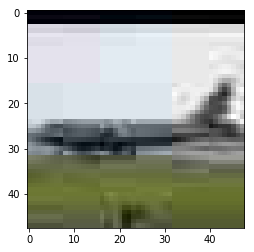

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

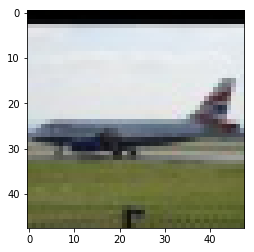

tensor([[[5.1032e-03, 2.9155e-04, 4.5217e-05,  ..., 1.6969e-05,
          1.0896e-04, 3.0417e-03],
         [1.6063e-02, 1.3536e-03, 3.0495e-04,  ..., 1.1558e-04,
          4.4961e-04, 1.1703e-02],
         [2.1761e-01, 1.2879e-01, 6.7415e-02,  ..., 3.4398e-02,
          5.1349e-02, 1.5589e-01],
         ...,
         [3.9177e-01, 3.7634e-01, 3.9229e-01,  ..., 3.8440e-01,
          3.7447e-01, 3.8866e-01],
         [3.6333e-01, 3.3277e-01, 3.3194e-01,  ..., 3.2300e-01,
          3.3018e-01, 3.6495e-01],
         [3.6734e-01, 3.1673e-01, 3.0801e-01,  ..., 3.0757e-01,
          3.2503e-01, 3.6035e-01]],

        [[1.1422e-02, 4.1779e-04, 7.7506e-05,  ..., 2.8951e-05,
          1.4859e-04, 6.0483e-03],
         [1.1220e-02, 1.2717e-03, 2.0243e-04,  ..., 1.1775e-04,
          3.9147e-04, 1.5698e-02],
         [1.8583e-01, 1.0910e-01, 4.1785e-02,  ..., 2.4520e-02,
          3.3576e-02, 1.5900e-01],
         ...,
         [3.6828e-01, 3.5235e-01, 3.5122e-01,  ..., 3.4584e-01,
          3.281

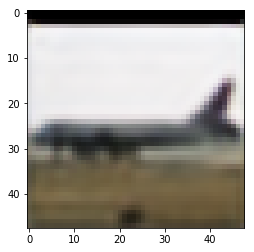




1it [00:00,  1.13it/s]


2it [00:01,  1.36it/s]


3it [00:01,  1.64it/s]


4it [00:01,  1.91it/s]


5it [00:02,  2.15it/s]


6it [00:02,  2.38it/s]


7it [00:02,  2.57it/s]


8it [00:03,  2.70it/s]


9it [00:03,  2.82it/s]


10it [00:03,  2.90it/s]


11it [00:04,  2.93it/s]


12it [00:04,  2.97it/s]


13it [00:04,  3.03it/s]


14it [00:05,  3.06it/s]


15it [00:05,  3.00it/s]


16it [00:05,  3.06it/s]


17it [00:06,  3.09it/s]


18it [00:06,  3.07it/s]


19it [00:06,  3.08it/s]


20it [00:07,  3.07it/s]


21it [00:07,  3.04it/s]


22it [00:07,  3.04it/s]


23it [00:08,  3.08it/s]


24it [00:08,  3.07it/s]


25it [00:08,  3.08it/s]


26it [00:09,  3.11it/s]


27it [00:09,  3.08it/s]


28it [00:09,  3.10it/s]


29it [00:10,  3.12it/s]


30it [00:10,  3.11it/s]


31it [00:10,  3.08it/s]


32it [00:10,  3.11it/s]


33it [00:11,  3.13it/s]


34it [00:11,  3.03it/s]


35it [00:11,  3.06it/s]


36it [00:12,  3.09it/s]


37it [00:12,  3.09it/s]


38it [00:12,  3.11it/s]


39it [00:13,  3.14

Epoch:  2 | train loss: 0.0067
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


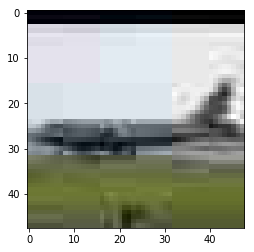

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

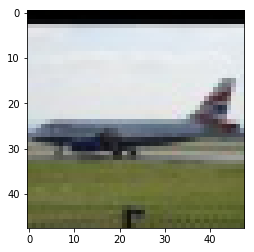

tensor([[[4.5798e-03, 2.4273e-04, 3.9789e-05,  ..., 3.0404e-05,
          1.7765e-04, 3.9068e-03],
         [1.8075e-02, 1.5615e-03, 4.2435e-04,  ..., 2.9752e-04,
          9.7588e-04, 1.6870e-02],
         [2.2702e-01, 1.3984e-01, 8.9895e-02,  ..., 6.5770e-02,
          8.6755e-02, 1.9208e-01],
         ...,
         [3.9857e-01, 3.9018e-01, 4.0821e-01,  ..., 3.9789e-01,
          3.6593e-01, 3.6132e-01],
         [3.7472e-01, 3.5227e-01, 3.5839e-01,  ..., 3.5403e-01,
          3.3666e-01, 3.5117e-01],
         [3.7458e-01, 3.3096e-01, 3.2642e-01,  ..., 3.3656e-01,
          3.3637e-01, 3.5597e-01]],

        [[1.0591e-02, 3.1572e-04, 5.7746e-05,  ..., 4.5189e-05,
          2.1631e-04, 7.0487e-03],
         [1.3549e-02, 1.4206e-03, 2.7397e-04,  ..., 2.8529e-04,
          8.0638e-04, 1.9879e-02],
         [2.2652e-01, 1.3588e-01, 7.0331e-02,  ..., 5.5067e-02,
          6.4444e-02, 1.8821e-01],
         ...,
         [3.8663e-01, 3.7950e-01, 3.8668e-01,  ..., 3.8285e-01,
          3.525

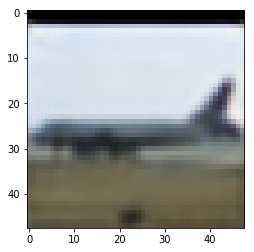




101it [00:34,  2.01it/s]


102it [00:34,  2.22it/s]


103it [00:34,  2.43it/s]


104it [00:35,  2.57it/s]


105it [00:35,  2.64it/s]


106it [00:35,  2.71it/s]


107it [00:36,  2.77it/s]


108it [00:36,  2.80it/s]


109it [00:36,  2.84it/s]


110it [00:37,  2.88it/s]


111it [00:37,  2.89it/s]


112it [00:37,  2.91it/s]


113it [00:38,  2.89it/s]


114it [00:38,  2.87it/s]


115it [00:38,  2.87it/s]


116it [00:39,  2.87it/s]


117it [00:39,  2.89it/s]


118it [00:39,  2.90it/s]


119it [00:40,  2.85it/s]


120it [00:40,  2.85it/s]


121it [00:41,  2.86it/s]


122it [00:41,  2.84it/s]


123it [00:41,  2.86it/s]


124it [00:42,  2.85it/s]


125it [00:42,  2.82it/s]


126it [00:42,  2.79it/s]


127it [00:43,  2.81it/s]


128it [00:43,  2.80it/s]


129it [00:43,  2.82it/s]


130it [00:44,  2.82it/s]


131it [00:44,  2.82it/s]


132it [00:44,  2.84it/s]


133it [00:45,  2.84it/s]


134it [00:45,  2.81it/s]


135it [00:46,  2.82it/s]


136it [00:46,  2.83it/s]


137it [00:46,  2.84it/s]


Epoch:  2 | train loss: 0.0056
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


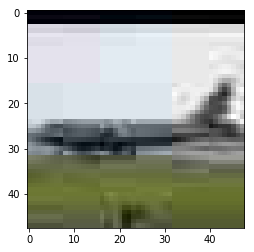

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

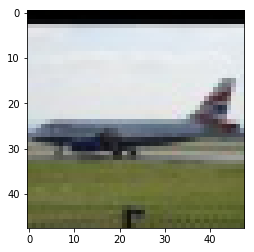

tensor([[[2.2163e-03, 8.8580e-05, 1.3571e-05,  ..., 1.0743e-05,
          7.1515e-05, 2.3006e-03],
         [1.0940e-02, 8.3809e-04, 2.0726e-04,  ..., 1.4265e-04,
          4.7329e-04, 1.1556e-02],
         [2.2531e-01, 1.4649e-01, 8.9738e-02,  ..., 5.8841e-02,
          7.4077e-02, 1.6810e-01],
         ...,
         [4.0211e-01, 3.9862e-01, 4.2036e-01,  ..., 4.0360e-01,
          3.8930e-01, 3.8514e-01],
         [3.8038e-01, 3.6312e-01, 3.7288e-01,  ..., 3.6539e-01,
          3.6049e-01, 3.7066e-01],
         [3.7866e-01, 3.3842e-01, 3.3710e-01,  ..., 3.5402e-01,
          3.5628e-01, 3.6892e-01]],

        [[6.7890e-03, 1.7805e-04, 3.3112e-05,  ..., 2.4784e-05,
          1.1944e-04, 5.4430e-03],
         [8.4580e-03, 9.7142e-04, 2.0075e-04,  ..., 2.2089e-04,
          6.1134e-04, 1.8543e-02],
         [2.1224e-01, 1.4713e-01, 7.5184e-02,  ..., 5.3914e-02,
          6.5720e-02, 1.9273e-01],
         ...,
         [3.8880e-01, 3.8754e-01, 4.0074e-01,  ..., 3.8919e-01,
          3.678

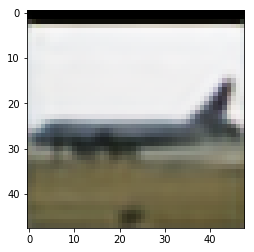




201it [01:09,  1.96it/s]


202it [01:09,  2.17it/s]


203it [01:10,  2.35it/s]


204it [01:10,  2.49it/s]


205it [01:10,  2.60it/s]


206it [01:11,  2.70it/s]


207it [01:11,  2.73it/s]


208it [01:11,  2.80it/s]


209it [01:12,  2.84it/s]


210it [01:12,  2.87it/s]


211it [01:12,  2.89it/s]


212it [01:13,  2.90it/s]


213it [01:13,  2.88it/s]


214it [01:13,  2.89it/s]


215it [01:14,  2.85it/s]


216it [01:14,  2.89it/s]


217it [01:14,  2.92it/s]


218it [01:15,  2.94it/s]


219it [01:15,  2.94it/s]


220it [01:16,  2.94it/s]


221it [01:16,  2.95it/s]


222it [01:16,  2.94it/s]


223it [01:17,  2.94it/s]


224it [01:17,  2.93it/s]


225it [01:17,  2.91it/s]


226it [01:18,  2.94it/s]


227it [01:18,  2.95it/s]


228it [01:18,  2.95it/s]


229it [01:19,  2.96it/s]


230it [01:19,  2.96it/s]


231it [01:19,  2.90it/s]


232it [01:20,  2.93it/s]


233it [01:20,  2.93it/s]


234it [01:20,  2.95it/s]


235it [01:21,  2.97it/s]


236it [01:21,  2.98it/s]


237it [01:21,  2.94it/s]


Epoch:  2 | train loss: 0.0050
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


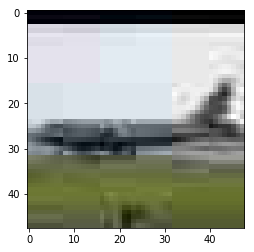

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

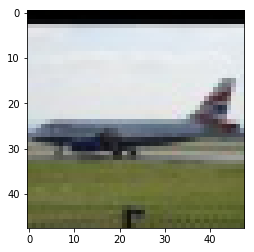

tensor([[[4.1954e-03, 2.4015e-04, 4.5777e-05,  ..., 3.6152e-05,
          1.8133e-04, 3.7740e-03],
         [1.3825e-02, 1.3128e-03, 4.0565e-04,  ..., 3.1035e-04,
          8.3946e-04, 1.3774e-02],
         [1.8406e-01, 1.1647e-01, 8.0634e-02,  ..., 6.4826e-02,
          7.6766e-02, 1.4974e-01],
         ...,
         [4.1048e-01, 4.0473e-01, 4.2080e-01,  ..., 3.9907e-01,
          3.9069e-01, 3.8799e-01],
         [3.8615e-01, 3.6401e-01, 3.7046e-01,  ..., 3.6006e-01,
          3.6071e-01, 3.6738e-01],
         [3.7589e-01, 3.3260e-01, 3.2807e-01,  ..., 3.3978e-01,
          3.4113e-01, 3.5704e-01]],

        [[8.9813e-03, 2.7361e-04, 6.0986e-05,  ..., 4.5272e-05,
          1.9457e-04, 6.4971e-03],
         [9.8244e-03, 9.4915e-04, 2.4413e-04,  ..., 2.6274e-04,
          6.5896e-04, 1.6724e-02],
         [1.6377e-01, 8.8684e-02, 5.1539e-02,  ..., 4.2597e-02,
          5.0680e-02, 1.7517e-01],
         ...,
         [3.7892e-01, 3.6144e-01, 3.7059e-01,  ..., 3.5326e-01,
          3.406

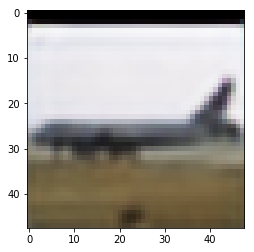




301it [01:43,  2.07it/s]


302it [01:44,  2.29it/s]


303it [01:44,  2.42it/s]


304it [01:44,  2.60it/s]


305it [01:45,  2.73it/s]


306it [01:45,  2.75it/s]


307it [01:45,  2.83it/s]


308it [01:46,  2.90it/s]


309it [01:46,  2.93it/s]


310it [01:46,  2.94it/s]


311it [01:47,  2.97it/s]


312it [01:47,  2.92it/s]


313it [01:47,  3.47it/s]





0it [00:00, ?it/s]

Epoch:  3 | train loss: 0.0055
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


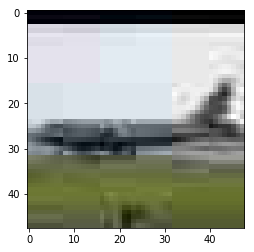

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

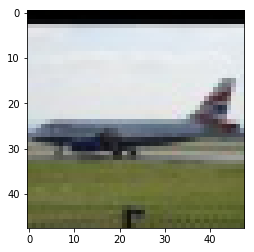

tensor([[[3.5468e-03, 1.7825e-04, 3.1731e-05,  ..., 3.0070e-05,
          1.6954e-04, 4.0099e-03],
         [1.0551e-02, 7.9923e-04, 2.2463e-04,  ..., 2.1195e-04,
          6.6563e-04, 1.2775e-02],
         [1.5268e-01, 8.0452e-02, 5.0501e-02,  ..., 4.2630e-02,
          5.2251e-02, 1.1636e-01],
         ...,
         [3.9666e-01, 3.9071e-01, 4.0978e-01,  ..., 3.9377e-01,
          3.8133e-01, 3.7939e-01],
         [3.7486e-01, 3.5395e-01, 3.6421e-01,  ..., 3.5753e-01,
          3.5436e-01, 3.6184e-01],
         [3.6689e-01, 3.2605e-01, 3.2659e-01,  ..., 3.3436e-01,
          3.3349e-01, 3.4991e-01]],

        [[9.1187e-03, 2.8432e-04, 6.8213e-05,  ..., 5.6850e-05,
          2.5608e-04, 7.9683e-03],
         [9.5027e-03, 8.9221e-04, 2.2705e-04,  ..., 3.1167e-04,
          8.2306e-04, 1.8183e-02],
         [1.5145e-01, 7.9512e-02, 4.2928e-02,  ..., 4.0787e-02,
          4.7635e-02, 1.4653e-01],
         ...,
         [3.6794e-01, 3.5012e-01, 3.6025e-01,  ..., 3.5370e-01,
          3.374

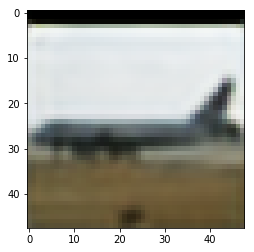




1it [00:00,  1.14it/s]


2it [00:01,  1.40it/s]


3it [00:01,  1.67it/s]


4it [00:01,  1.93it/s]


5it [00:02,  2.17it/s]


6it [00:02,  2.40it/s]


7it [00:02,  2.57it/s]


8it [00:03,  2.69it/s]


9it [00:03,  2.80it/s]


10it [00:03,  2.88it/s]


11it [00:04,  2.89it/s]


12it [00:04,  2.94it/s]


13it [00:04,  2.98it/s]


14it [00:05,  3.00it/s]


15it [00:05,  3.04it/s]


16it [00:05,  3.03it/s]


17it [00:06,  3.00it/s]


18it [00:06,  3.04it/s]


19it [00:06,  2.99it/s]


20it [00:07,  2.98it/s]


21it [00:07,  3.03it/s]


22it [00:07,  3.06it/s]


23it [00:08,  3.02it/s]


24it [00:08,  3.01it/s]


25it [00:08,  3.05it/s]


26it [00:09,  3.06it/s]


27it [00:09,  3.08it/s]


28it [00:09,  3.11it/s]


29it [00:10,  3.08it/s]


30it [00:10,  3.07it/s]


31it [00:10,  3.04it/s]


32it [00:11,  3.04it/s]


33it [00:11,  3.00it/s]


34it [00:11,  3.01it/s]


35it [00:12,  3.05it/s]


36it [00:12,  3.04it/s]


37it [00:12,  3.04it/s]


38it [00:13,  3.04it/s]


39it [00:13,  3.00

Epoch:  3 | train loss: 0.0049
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


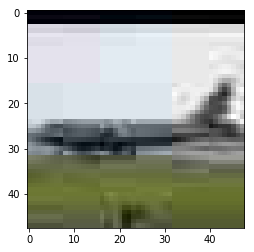

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

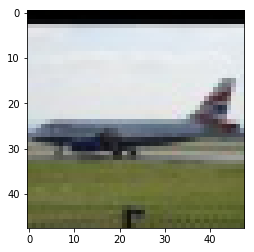

tensor([[[3.4766e-03, 1.7068e-04, 2.8265e-05,  ..., 3.1614e-05,
          1.7213e-04, 3.7912e-03],
         [1.2342e-02, 1.0313e-03, 2.8293e-04,  ..., 2.8934e-04,
          8.0196e-04, 1.3445e-02],
         [1.6612e-01, 1.0009e-01, 6.9778e-02,  ..., 5.0706e-02,
          5.7963e-02, 1.1998e-01],
         ...,
         [3.9662e-01, 3.9570e-01, 4.1853e-01,  ..., 3.9980e-01,
          3.8569e-01, 3.7728e-01],
         [3.7361e-01, 3.5761e-01, 3.7061e-01,  ..., 3.6432e-01,
          3.5799e-01, 3.6273e-01],
         [3.6314e-01, 3.2520e-01, 3.2744e-01,  ..., 3.4108e-01,
          3.4120e-01, 3.5504e-01]],

        [[7.4776e-03, 1.9959e-04, 4.0977e-05,  ..., 4.5093e-05,
          1.9925e-04, 6.3843e-03],
         [9.0132e-03, 8.8552e-04, 2.1731e-04,  ..., 3.2310e-04,
          8.2169e-04, 1.6651e-02],
         [1.5922e-01, 9.6676e-02, 5.6766e-02,  ..., 4.2610e-02,
          4.9554e-02, 1.3868e-01],
         ...,
         [3.7776e-01, 3.7669e-01, 3.9424e-01,  ..., 3.8200e-01,
          3.589

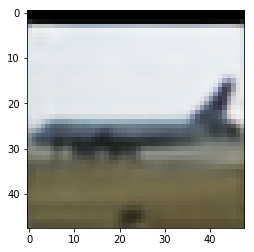




101it [00:34,  2.03it/s]


102it [00:34,  2.24it/s]


103it [00:35,  2.42it/s]


104it [00:35,  2.60it/s]


105it [00:35,  2.75it/s]


106it [00:36,  2.84it/s]


107it [00:36,  2.94it/s]


108it [00:36,  2.97it/s]


109it [00:37,  2.98it/s]


110it [00:37,  3.02it/s]


111it [00:37,  3.04it/s]


112it [00:38,  3.01it/s]


113it [00:38,  3.03it/s]


114it [00:38,  3.05it/s]


115it [00:39,  3.06it/s]


116it [00:39,  3.05it/s]


117it [00:39,  3.05it/s]


118it [00:39,  3.09it/s]


119it [00:40,  3.07it/s]


120it [00:40,  3.09it/s]


121it [00:40,  3.12it/s]


122it [00:41,  3.05it/s]


123it [00:41,  3.09it/s]


124it [00:41,  3.12it/s]


125it [00:42,  3.10it/s]


126it [00:42,  3.13it/s]


127it [00:42,  3.10it/s]


128it [00:43,  3.07it/s]


129it [00:43,  3.06it/s]


130it [00:43,  3.08it/s]


131it [00:44,  3.09it/s]


132it [00:44,  3.06it/s]


133it [00:44,  3.08it/s]


134it [00:45,  3.12it/s]


135it [00:45,  3.09it/s]


136it [00:45,  3.08it/s]


137it [00:46,  3.07it/s]


Epoch:  3 | train loss: 0.0042
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


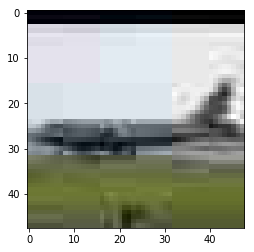

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

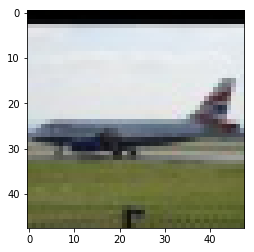

tensor([[[1.4181e-03, 4.1537e-05, 5.0468e-06,  ..., 4.2720e-06,
          3.8639e-05, 1.6361e-03],
         [6.7777e-03, 3.7140e-04, 7.5596e-05,  ..., 6.5187e-05,
          2.6304e-04, 7.1089e-03],
         [1.6041e-01, 8.7894e-02, 5.6470e-02,  ..., 5.3647e-02,
          6.0974e-02, 1.2111e-01],
         ...,
         [4.0104e-01, 3.9910e-01, 4.2193e-01,  ..., 3.9736e-01,
          3.8228e-01, 3.6974e-01],
         [3.7871e-01, 3.5918e-01, 3.6864e-01,  ..., 3.6207e-01,
          3.5653e-01, 3.5608e-01],
         [3.6624e-01, 3.2270e-01, 3.1861e-01,  ..., 3.3915e-01,
          3.3827e-01, 3.4980e-01]],

        [[3.8968e-03, 5.9170e-05, 9.3744e-06,  ..., 9.3742e-06,
          6.5073e-05, 3.3101e-03],
         [5.2770e-03, 3.7251e-04, 7.4728e-05,  ..., 1.0594e-04,
          3.8632e-04, 1.0043e-02],
         [1.4743e-01, 8.4720e-02, 4.7323e-02,  ..., 5.1533e-02,
          6.2248e-02, 1.3779e-01],
         ...,
         [3.7126e-01, 3.6915e-01, 3.8789e-01,  ..., 3.6730e-01,
          3.488

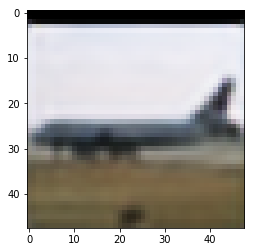




201it [01:07,  2.06it/s]


202it [01:08,  2.25it/s]


203it [01:08,  2.46it/s]


204it [01:08,  2.61it/s]


205it [01:09,  2.77it/s]


206it [01:09,  2.87it/s]


207it [01:09,  2.94it/s]


208it [01:10,  2.99it/s]


209it [01:10,  3.02it/s]


210it [01:10,  3.08it/s]


211it [01:10,  3.09it/s]


212it [01:11,  3.04it/s]


213it [01:11,  2.99it/s]


214it [01:11,  3.04it/s]


215it [01:12,  3.06it/s]


216it [01:12,  3.08it/s]


217it [01:12,  3.10it/s]


218it [01:13,  3.09it/s]


219it [01:13,  3.14it/s]


220it [01:13,  3.16it/s]


221it [01:14,  3.15it/s]


222it [01:14,  3.11it/s]


223it [01:14,  3.11it/s]


224it [01:15,  3.11it/s]


225it [01:15,  3.04it/s]


226it [01:15,  3.06it/s]


227it [01:16,  3.08it/s]


228it [01:16,  3.06it/s]


229it [01:16,  3.10it/s]


230it [01:17,  3.12it/s]


231it [01:17,  3.11it/s]


232it [01:17,  3.13it/s]


233it [01:18,  3.13it/s]


234it [01:18,  3.11it/s]


235it [01:18,  3.08it/s]


236it [01:19,  3.07it/s]


237it [01:19,  3.07it/s]


Epoch:  3 | train loss: 0.0044
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


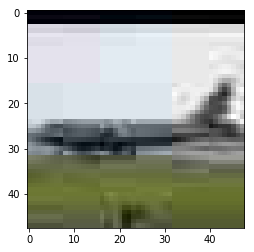

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

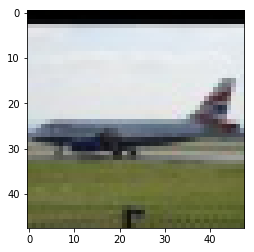

tensor([[[9.6935e-04, 1.8785e-05, 1.6827e-06,  ..., 4.0022e-06,
          3.6499e-05, 1.4163e-03],
         [5.3105e-03, 2.1174e-04, 3.8501e-05,  ..., 7.4514e-05,
          2.8845e-04, 7.5549e-03],
         [1.7461e-01, 9.8599e-02, 7.2538e-02,  ..., 7.6981e-02,
          8.0334e-02, 1.4719e-01],
         ...,
         [4.0244e-01, 3.9755e-01, 4.1491e-01,  ..., 4.0454e-01,
          4.0107e-01, 3.9138e-01],
         [3.7245e-01, 3.5093e-01, 3.5609e-01,  ..., 3.7628e-01,
          3.7971e-01, 3.7443e-01],
         [3.6478e-01, 3.1838e-01, 3.1419e-01,  ..., 3.6252e-01,
          3.5857e-01, 3.5861e-01]],

        [[2.4765e-03, 2.3616e-05, 2.8539e-06,  ..., 6.8608e-06,
          5.2120e-05, 2.7318e-03],
         [3.7701e-03, 1.7081e-04, 2.6975e-05,  ..., 7.7636e-05,
          2.9455e-04, 8.3417e-03],
         [1.5098e-01, 8.4697e-02, 5.0031e-02,  ..., 4.9362e-02,
          5.6825e-02, 1.4095e-01],
         ...,
         [3.7560e-01, 3.7496e-01, 3.8782e-01,  ..., 3.7357e-01,
          3.610

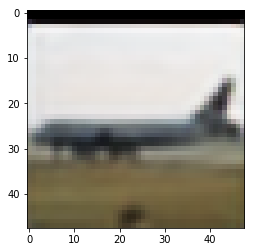




301it [01:40,  1.97it/s]


302it [01:41,  2.17it/s]


303it [01:41,  2.38it/s]


304it [01:41,  2.53it/s]


305it [01:42,  2.65it/s]


306it [01:42,  2.75it/s]


307it [01:42,  2.75it/s]


308it [01:43,  2.76it/s]


309it [01:43,  2.83it/s]


310it [01:43,  2.88it/s]


311it [01:44,  2.92it/s]


312it [01:44,  2.91it/s]


313it [01:44,  3.48it/s]





0it [00:00, ?it/s]

Epoch:  4 | train loss: 0.0048
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


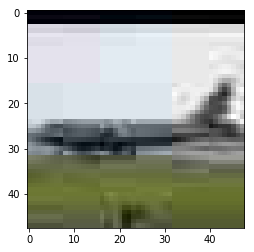

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

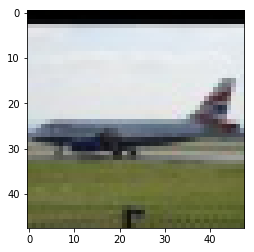

tensor([[[1.6644e-03, 5.6055e-05, 8.0599e-06,  ..., 1.1380e-05,
          7.6246e-05, 2.0410e-03],
         [5.3413e-03, 3.2579e-04, 8.8000e-05,  ..., 1.4691e-04,
          4.6239e-04, 8.9754e-03],
         [1.1210e-01, 6.0748e-02, 4.8328e-02,  ..., 5.5665e-02,
          5.8876e-02, 1.1258e-01],
         ...,
         [4.0524e-01, 4.0623e-01, 4.2061e-01,  ..., 4.0462e-01,
          4.0970e-01, 3.9721e-01],
         [3.8101e-01, 3.7099e-01, 3.7530e-01,  ..., 3.7834e-01,
          3.8948e-01, 3.8002e-01],
         [3.7573e-01, 3.3661e-01, 3.3244e-01,  ..., 3.5478e-01,
          3.5775e-01, 3.5747e-01]],

        [[4.2225e-03, 7.0148e-05, 1.3402e-05,  ..., 2.2079e-05,
          1.2260e-04, 3.8567e-03],
         [4.9668e-03, 3.2959e-04, 8.2621e-05,  ..., 2.0749e-04,
          6.1864e-04, 1.0412e-02],
         [1.1789e-01, 6.5473e-02, 4.3879e-02,  ..., 5.4429e-02,
          5.7971e-02, 1.2140e-01],
         ...,
         [3.7891e-01, 3.8493e-01, 3.9618e-01,  ..., 3.8357e-01,
          3.709

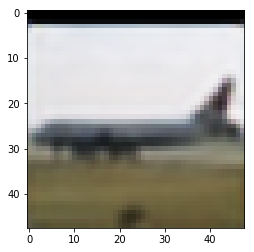




1it [00:00,  1.15it/s]


2it [00:01,  1.41it/s]


3it [00:01,  1.69it/s]


4it [00:01,  1.94it/s]


5it [00:02,  2.19it/s]


6it [00:02,  2.40it/s]


7it [00:02,  2.56it/s]


8it [00:03,  2.68it/s]


9it [00:03,  2.78it/s]


10it [00:03,  2.83it/s]


11it [00:04,  2.92it/s]


12it [00:04,  2.97it/s]


13it [00:04,  2.94it/s]


14it [00:05,  2.98it/s]


15it [00:05,  2.99it/s]


16it [00:05,  3.00it/s]


17it [00:06,  3.02it/s]


18it [00:06,  3.06it/s]


19it [00:06,  3.03it/s]


20it [00:07,  3.05it/s]


21it [00:07,  3.07it/s]


22it [00:07,  3.09it/s]


23it [00:08,  3.06it/s]


24it [00:08,  3.08it/s]


25it [00:08,  2.98it/s]


26it [00:09,  2.98it/s]


27it [00:09,  3.01it/s]


28it [00:09,  3.05it/s]


29it [00:10,  3.02it/s]


30it [00:10,  3.05it/s]


31it [00:10,  3.05it/s]


32it [00:11,  3.04it/s]


33it [00:11,  3.06it/s]


34it [00:11,  3.06it/s]


35it [00:12,  3.02it/s]


36it [00:12,  3.06it/s]


37it [00:12,  3.09it/s]


38it [00:13,  3.06it/s]


39it [00:13,  3.07

Epoch:  4 | train loss: 0.0047
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


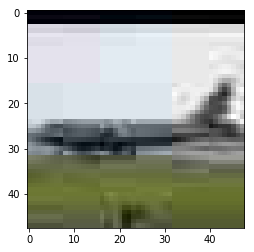

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

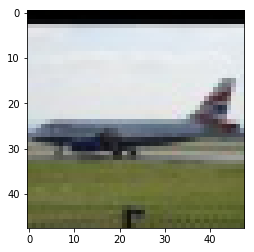

tensor([[[1.5360e-03, 5.4932e-05, 8.2216e-06,  ..., 6.9609e-06,
          4.9153e-05, 1.5000e-03],
         [6.6515e-03, 3.9565e-04, 1.0473e-04,  ..., 8.5464e-05,
          2.5609e-04, 6.3902e-03],
         [1.6800e-01, 1.0247e-01, 8.3274e-02,  ..., 8.1181e-02,
          7.4066e-02, 1.3736e-01],
         ...,
         [4.1638e-01, 4.2284e-01, 4.3924e-01,  ..., 4.0883e-01,
          4.0590e-01, 3.8908e-01],
         [3.9274e-01, 3.8827e-01, 3.9593e-01,  ..., 3.8730e-01,
          3.8879e-01, 3.7279e-01],
         [3.8748e-01, 3.4781e-01, 3.4309e-01,  ..., 3.6839e-01,
          3.6207e-01, 3.5721e-01]],

        [[4.2179e-03, 7.6870e-05, 1.6199e-05,  ..., 1.8392e-05,
          1.0801e-04, 3.7127e-03],
         [5.8516e-03, 4.3497e-04, 1.1338e-04,  ..., 1.7154e-04,
          4.8835e-04, 1.0135e-02],
         [1.5313e-01, 9.7484e-02, 6.9150e-02,  ..., 7.7561e-02,
          8.1114e-02, 1.6251e-01],
         ...,
         [3.8828e-01, 4.0509e-01, 4.2323e-01,  ..., 4.0248e-01,
          3.875

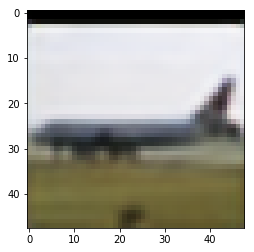




101it [00:34,  1.59it/s]


102it [00:35,  1.85it/s]


103it [00:35,  2.11it/s]


104it [00:35,  2.32it/s]


105it [00:36,  2.49it/s]


106it [00:36,  2.65it/s]


107it [00:36,  2.74it/s]


108it [00:37,  2.85it/s]


109it [00:37,  2.91it/s]


110it [00:37,  2.94it/s]


111it [00:38,  2.93it/s]


112it [00:38,  2.99it/s]


113it [00:38,  3.01it/s]


114it [00:39,  2.98it/s]


115it [00:39,  3.00it/s]


116it [00:39,  3.05it/s]


117it [00:40,  2.96it/s]


118it [00:40,  2.99it/s]


119it [00:40,  3.02it/s]


120it [00:41,  2.99it/s]


121it [00:41,  3.01it/s]


122it [00:41,  3.06it/s]


123it [00:42,  3.03it/s]


124it [00:42,  3.06it/s]


125it [00:42,  3.07it/s]


126it [00:42,  3.05it/s]


127it [00:43,  3.04it/s]


128it [00:43,  3.07it/s]


129it [00:43,  3.06it/s]


130it [00:44,  3.06it/s]


131it [00:44,  3.07it/s]


132it [00:44,  3.06it/s]


133it [00:45,  3.06it/s]


134it [00:45,  3.07it/s]


135it [00:45,  3.05it/s]


136it [00:46,  3.06it/s]


137it [00:46,  3.02it/s]


Epoch:  4 | train loss: 0.0047
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


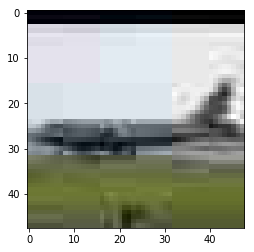

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

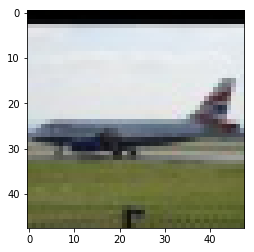

tensor([[[1.5600e-03, 5.2586e-05, 7.9678e-06,  ..., 7.2542e-06,
          5.5810e-05, 1.6512e-03],
         [5.7075e-03, 4.0680e-04, 1.3496e-04,  ..., 1.1433e-04,
          3.5009e-04, 7.8672e-03],
         [1.3217e-01, 9.2848e-02, 9.7942e-02,  ..., 9.9327e-02,
          8.6948e-02, 1.4285e-01],
         ...,
         [4.0057e-01, 4.0577e-01, 4.1342e-01,  ..., 3.9290e-01,
          3.8439e-01, 3.6281e-01],
         [3.7710e-01, 3.7220e-01, 3.7169e-01,  ..., 3.7847e-01,
          3.6725e-01, 3.4530e-01],
         [3.7175e-01, 3.3092e-01, 3.2219e-01,  ..., 3.5914e-01,
          3.3778e-01, 3.2519e-01]],

        [[3.3015e-03, 5.3804e-05, 1.1552e-05,  ..., 1.5238e-05,
          1.0184e-04, 3.6763e-03],
         [4.4497e-03, 3.0768e-04, 9.3371e-05,  ..., 1.3736e-04,
          4.4718e-04, 1.0511e-02],
         [1.1834e-01, 7.9738e-02, 6.8674e-02,  ..., 6.6262e-02,
          6.7593e-02, 1.6120e-01],
         ...,
         [3.6819e-01, 3.8331e-01, 3.8904e-01,  ..., 3.6245e-01,
          3.385

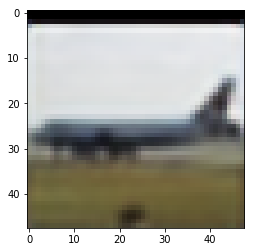




201it [01:08,  2.06it/s]


202it [01:08,  2.28it/s]


203it [01:08,  2.45it/s]


204it [01:09,  2.59it/s]


205it [01:09,  2.72it/s]


206it [01:09,  2.81it/s]


207it [01:10,  2.88it/s]


208it [01:10,  2.92it/s]


209it [01:10,  2.97it/s]


210it [01:11,  2.99it/s]


211it [01:11,  2.91it/s]


212it [01:11,  2.96it/s]


213it [01:12,  2.94it/s]


214it [01:12,  2.97it/s]


215it [01:12,  2.99it/s]


216it [01:13,  2.95it/s]


217it [01:13,  2.98it/s]


218it [01:13,  3.00it/s]


219it [01:14,  3.00it/s]


220it [01:14,  3.02it/s]


221it [01:14,  3.03it/s]


222it [01:15,  2.98it/s]


223it [01:15,  3.00it/s]


224it [01:15,  3.02it/s]


225it [01:16,  2.99it/s]


226it [01:16,  2.99it/s]


227it [01:16,  2.97it/s]


228it [01:17,  2.99it/s]


229it [01:17,  3.00it/s]


230it [01:17,  3.01it/s]


231it [01:18,  2.92it/s]


232it [01:18,  2.98it/s]


233it [01:18,  2.98it/s]


234it [01:19,  2.94it/s]


235it [01:19,  2.99it/s]


236it [01:19,  3.02it/s]


237it [01:20,  2.99it/s]


Epoch:  4 | train loss: 0.0055
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


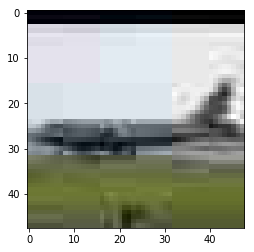

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

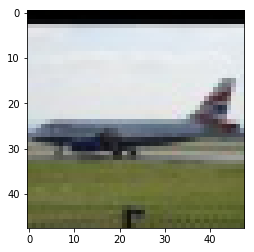

tensor([[[1.8074e-03, 5.5394e-05, 8.8460e-06,  ..., 1.0148e-05,
          6.0636e-05, 1.8607e-03],
         [6.9062e-03, 3.7733e-04, 1.0547e-04,  ..., 6.9265e-05,
          2.0128e-04, 6.9322e-03],
         [1.8188e-01, 1.1520e-01, 8.7795e-02,  ..., 5.3975e-02,
          6.4505e-02, 1.5166e-01],
         ...,
         [3.9361e-01, 4.0133e-01, 4.2105e-01,  ..., 3.9708e-01,
          3.8491e-01, 3.8385e-01],
         [3.6437e-01, 3.5864e-01, 3.7200e-01,  ..., 3.5969e-01,
          3.6298e-01, 3.7441e-01],
         [3.5267e-01, 3.1625e-01, 3.1773e-01,  ..., 3.3383e-01,
          3.4477e-01, 3.6932e-01]],

        [[4.6181e-03, 8.5362e-05, 1.7271e-05,  ..., 2.1893e-05,
          1.1705e-04, 5.2612e-03],
         [7.4072e-03, 5.4162e-04, 1.3336e-04,  ..., 1.3754e-04,
          3.9085e-04, 1.2992e-02],
         [1.8545e-01, 1.2045e-01, 7.8097e-02,  ..., 4.7801e-02,
          6.0841e-02, 1.8262e-01],
         ...,
         [3.7979e-01, 3.9038e-01, 3.9863e-01,  ..., 3.8309e-01,
          3.815

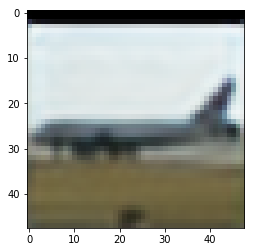




301it [01:41,  2.04it/s]


302it [01:42,  2.25it/s]


303it [01:42,  2.46it/s]


304it [01:42,  2.52it/s]


305it [01:43,  2.67it/s]


306it [01:43,  2.78it/s]


307it [01:43,  2.85it/s]


308it [01:44,  2.92it/s]


309it [01:44,  2.98it/s]


310it [01:44,  3.00it/s]


311it [01:45,  3.02it/s]


312it [01:45,  3.04it/s]


313it [01:45,  3.61it/s]





0it [00:00, ?it/s]

Epoch:  5 | train loss: 0.0049
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


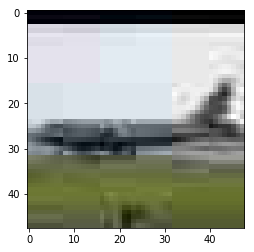

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

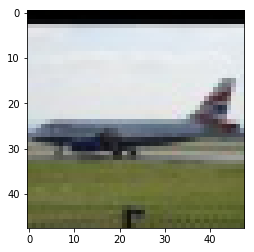

tensor([[[8.4427e-04, 1.7916e-05, 2.3128e-06,  ..., 6.1969e-06,
          4.4625e-05, 1.6384e-03],
         [4.5480e-03, 2.1832e-04, 5.3502e-05,  ..., 8.1794e-05,
          2.4701e-04, 7.1741e-03],
         [2.0809e-01, 1.4710e-01, 1.1384e-01,  ..., 1.2317e-01,
          1.1861e-01, 1.8849e-01],
         ...,
         [3.8149e-01, 4.0192e-01, 4.3438e-01,  ..., 4.0825e-01,
          3.9013e-01, 3.9012e-01],
         [3.5424e-01, 3.6348e-01, 3.9056e-01,  ..., 3.8481e-01,
          3.7630e-01, 3.8237e-01],
         [3.3943e-01, 3.1260e-01, 3.2566e-01,  ..., 3.6536e-01,
          3.6414e-01, 3.7778e-01]],

        [[2.7494e-03, 3.1867e-05, 5.0219e-06,  ..., 1.1894e-05,
          6.8192e-05, 2.9448e-03],
         [5.1974e-03, 2.9879e-04, 5.7449e-05,  ..., 1.0309e-04,
          2.7130e-04, 8.3170e-03],
         [1.9138e-01, 1.2798e-01, 7.8895e-02,  ..., 6.8948e-02,
          6.7377e-02, 1.6727e-01],
         ...,
         [3.5902e-01, 3.6622e-01, 3.8137e-01,  ..., 3.5040e-01,
          3.430

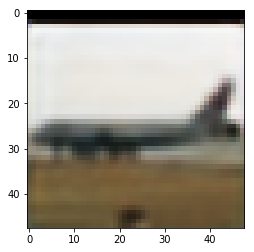




1it [00:00,  1.18it/s]


2it [00:01,  1.43it/s]


3it [00:01,  1.70it/s]


4it [00:01,  1.98it/s]


5it [00:02,  2.22it/s]


6it [00:02,  2.35it/s]


7it [00:02,  2.53it/s]


8it [00:03,  2.70it/s]


9it [00:03,  2.77it/s]


10it [00:03,  2.88it/s]


11it [00:04,  2.93it/s]


12it [00:04,  2.96it/s]


13it [00:04,  3.02it/s]


14it [00:05,  3.07it/s]


15it [00:05,  3.09it/s]


16it [00:05,  3.09it/s]


17it [00:06,  3.07it/s]


18it [00:06,  3.09it/s]


19it [00:06,  2.96it/s]


20it [00:07,  3.02it/s]


21it [00:07,  2.99it/s]


22it [00:07,  3.00it/s]


23it [00:08,  3.05it/s]


24it [00:08,  3.07it/s]


25it [00:08,  3.07it/s]


26it [00:09,  3.08it/s]


27it [00:09,  3.09it/s]


28it [00:09,  3.09it/s]


29it [00:10,  3.08it/s]


30it [00:10,  3.11it/s]


31it [00:10,  3.09it/s]


32it [00:10,  3.11it/s]


33it [00:11,  3.02it/s]


34it [00:11,  3.01it/s]


35it [00:11,  3.06it/s]


36it [00:12,  3.07it/s]


37it [00:12,  3.10it/s]


38it [00:12,  3.10it/s]


39it [00:13,  3.11

Epoch:  5 | train loss: 0.0057
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


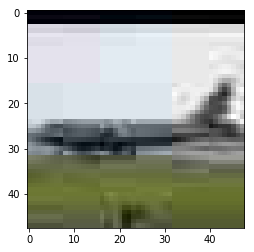

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

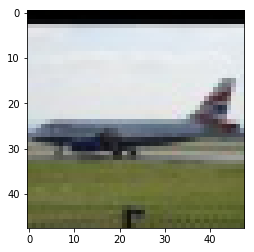

tensor([[[1.0338e-03, 2.2051e-05, 2.4769e-06,  ..., 5.7767e-06,
          4.2382e-05, 1.2625e-03],
         [4.1456e-03, 1.9556e-04, 4.5277e-05,  ..., 7.5457e-05,
          2.2778e-04, 5.1103e-03],
         [1.2434e-01, 8.6160e-02, 7.9858e-02,  ..., 1.0972e-01,
          1.0175e-01, 1.4983e-01],
         ...,
         [4.1470e-01, 4.2093e-01, 4.4574e-01,  ..., 4.1827e-01,
          4.2247e-01, 4.1700e-01],
         [3.8813e-01, 3.8620e-01, 4.0512e-01,  ..., 3.9765e-01,
          4.0653e-01, 3.9538e-01],
         [3.7213e-01, 3.3975e-01, 3.4419e-01,  ..., 3.7037e-01,
          3.6550e-01, 3.7011e-01]],

        [[2.0825e-03, 1.8535e-05, 2.6010e-06,  ..., 6.8946e-06,
          5.0641e-05, 1.8690e-03],
         [3.6260e-03, 1.6051e-04, 3.1735e-05,  ..., 6.9080e-05,
          2.2330e-04, 4.9962e-03],
         [1.1661e-01, 7.5304e-02, 5.6506e-02,  ..., 7.7840e-02,
          8.4472e-02, 1.5889e-01],
         ...,
         [3.8358e-01, 3.9294e-01, 4.1081e-01,  ..., 3.9157e-01,
          3.833

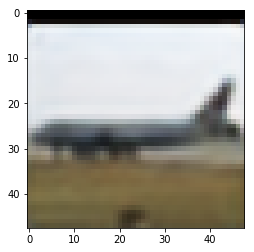




101it [00:33,  2.05it/s]


102it [00:34,  2.25it/s]


103it [00:34,  2.46it/s]


104it [00:34,  2.64it/s]


105it [00:35,  2.77it/s]


106it [00:35,  2.85it/s]


107it [00:35,  2.94it/s]


108it [00:36,  2.99it/s]


109it [00:36,  3.03it/s]


110it [00:36,  3.07it/s]


111it [00:37,  3.10it/s]


112it [00:37,  3.00it/s]


113it [00:37,  3.03it/s]


114it [00:38,  3.06it/s]


115it [00:38,  3.04it/s]


116it [00:38,  3.05it/s]


117it [00:39,  3.02it/s]


118it [00:39,  3.06it/s]


119it [00:39,  3.05it/s]


120it [00:40,  3.05it/s]


121it [00:40,  2.99it/s]


122it [00:40,  2.99it/s]


123it [00:41,  2.96it/s]


124it [00:41,  2.99it/s]


125it [00:41,  2.91it/s]


126it [00:42,  2.94it/s]


127it [00:42,  2.91it/s]


128it [00:42,  2.92it/s]


129it [00:43,  2.96it/s]


130it [00:43,  3.00it/s]


131it [00:43,  2.98it/s]


132it [00:44,  2.96it/s]


133it [00:44,  2.96it/s]


134it [00:44,  2.85it/s]


135it [00:45,  2.91it/s]


136it [00:45,  2.94it/s]


137it [00:45,  2.93it/s]


Epoch:  5 | train loss: 0.0049
torch.Size([1, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4078, 0.4078, 0.4078,  ..., 0.3412, 0.3412, 0.3412],
         [0.3765, 0.3765, 0.3765,  ..., 0.3294, 0.3294, 0.3294],
         [0.3020, 0.3020, 0.3020,  ..., 0.3255, 0.3255, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0353, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3922, 0.3922,  ..., 0.3569, 0.3569, 0.3569],
         [0.3176, 0.3176, 0.3176,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.0745, 0.0745,  ..., 0.0353, 0.0353, 0.0353],


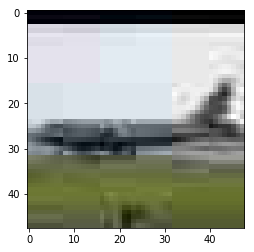

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4235, 0.4078, 0.4078,  ..., 0.3529, 0.3412, 0.3608],
         [0.4157, 0.3765, 0.3882,  ..., 0.2980, 0.3020, 0.3098],
         [0.3333, 0.2824, 0.3333,  ..., 0.3216, 0.3294, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0392, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0431],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.3961, 0.3843, 0.4039],
         [0.4196, 0.3804, 0.3922,  ..., 0.3373, 0.3412, 0.3490],
         [0.3490, 0.2980, 0.3490,  ..., 0.3569, 0.3647, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0510, 0.0510, 0.

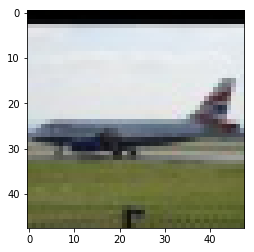

tensor([[[8.0179e-04, 1.9724e-05, 2.8500e-06,  ..., 6.2336e-06,
          4.0799e-05, 9.9691e-04],
         [2.6712e-03, 1.2983e-04, 3.5175e-05,  ..., 5.7297e-05,
          1.5821e-04, 3.3630e-03],
         [9.8114e-02, 6.3417e-02, 6.0810e-02,  ..., 6.3256e-02,
          5.5919e-02, 9.6671e-02],
         ...,
         [3.9306e-01, 3.9728e-01, 4.1441e-01,  ..., 3.9781e-01,
          3.9927e-01, 3.9971e-01],
         [3.6751e-01, 3.6568e-01, 3.7658e-01,  ..., 3.8056e-01,
          3.9740e-01, 3.8779e-01],
         [3.5898e-01, 3.2165e-01, 3.1983e-01,  ..., 3.3783e-01,
          3.5042e-01, 3.6409e-01]],

        [[1.9183e-03, 2.0110e-05, 3.7962e-06,  ..., 1.0109e-05,
          6.7017e-05, 2.0486e-03],
         [2.5010e-03, 9.9626e-05, 2.4029e-05,  ..., 5.3533e-05,
          1.6365e-04, 3.6784e-03],
         [9.0691e-02, 4.9986e-02, 3.8716e-02,  ..., 4.0909e-02,
          4.4940e-02, 1.0718e-01],
         ...,
         [3.6915e-01, 3.8065e-01, 3.9494e-01,  ..., 3.8799e-01,
          3.800

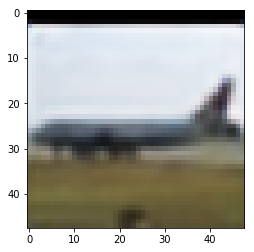




201it [01:08,  1.89it/s]


202it [01:08,  2.09it/s]


203it [01:09,  2.31it/s]


204it [01:09,  2.47it/s]


205it [01:10,  2.42it/s]


206it [01:10,  2.45it/s]


207it [01:10,  2.58it/s]


208it [01:11,  2.69it/s]


209it [01:11,  2.81it/s]


210it [01:11,  2.86it/s]


211it [01:12,  2.80it/s]


212it [01:12,  2.83it/s]


213it [01:12,  2.88it/s]


214it [01:13,  2.93it/s]


215it [01:13,  2.94it/s]


216it [01:13,  2.93it/s]


217it [01:14,  2.99it/s]


218it [01:14,  3.01it/s]


219it [01:14,  3.00it/s]


220it [01:15,  3.03it/s]


221it [01:15,  3.04it/s]


222it [01:15,  2.97it/s]


223it [01:16,  2.98it/s]


224it [01:16,  3.01it/s]


225it [01:16,  2.98it/s]


226it [01:17,  3.01it/s]


227it [01:17,  3.02it/s]


228it [01:17,  2.99it/s]


229it [01:18,  2.99it/s]


230it [01:18,  3.01it/s]


231it [01:18,  2.99it/s]


232it [01:19,  3.00it/s]


233it [01:19,  3.00it/s]


234it [01:19,  2.97it/s]


235it [01:20,  3.01it/s]


236it [01:20,  3.02it/s]


237it [01:20,  3.02it/s]


KeyboardInterrupt: ignored

In [17]:
in_data, original_data = train_dataset.get_train_data(n_plots)
autoencoder = ConvAutoencoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_func = loss = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[9,12,13], gamma=0.1)

for epoch in range(epochs):
    autoencoder.train()
    for step, (x, y) in tqdm.tqdm(enumerate(train_loader)):

        encoded, decoded = autoencoder(x) 
        loss = loss_func(decoded, y)
        optimizer.zero_grad()   # clear gradients for this training step
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step % 100 == 0:# and epoch in [0, 5, epochs - 1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item())
            _, decoded_data = autoencoder(original_data)
            print(in_data.shape)
            show_img(in_data.squeeze(0))
            show_img(original_data.squeeze(0))
            show_img(decoded_data.data.squeeze(0))
          
    scheduler.step()

tensor([[[0.3490, 0.3137, 0.2627,  ..., 0.6980, 0.6980, 0.6980],
         [0.3412, 0.3098, 0.2627,  ..., 0.7020, 0.7020, 0.7020],
         [0.3255, 0.2980, 0.2627,  ..., 0.7059, 0.7059, 0.7059],
         ...,
         [0.7059, 0.7059, 0.7020,  ..., 0.7176, 0.7765, 0.8392],
         [0.7098, 0.7137, 0.7176,  ..., 0.7059, 0.7333, 0.7686],
         [0.7098, 0.7216, 0.7255,  ..., 0.7098, 0.6745, 0.6431]],

        [[0.3059, 0.2706, 0.2196,  ..., 0.6980, 0.6980, 0.6980],
         [0.2980, 0.2667, 0.2196,  ..., 0.7020, 0.7020, 0.7020],
         [0.2824, 0.2549, 0.2196,  ..., 0.7059, 0.7059, 0.7059],
         ...,
         [0.7059, 0.7059, 0.7020,  ..., 0.7176, 0.7765, 0.8392],
         [0.7098, 0.7137, 0.7176,  ..., 0.7059, 0.7333, 0.7686],
         [0.7098, 0.7216, 0.7255,  ..., 0.7098, 0.6745, 0.6431]],

        [[0.3216, 0.2863, 0.2353,  ..., 0.6980, 0.6980, 0.6980],
         [0.3137, 0.2824, 0.2353,  ..., 0.7020, 0.7020, 0.7020],
         [0.2980, 0.2706, 0.2353,  ..., 0.7059, 0.7059, 0.

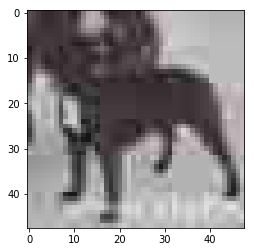

tensor([[[0.2953, 0.2531, 0.2268,  ..., 0.6766, 0.6732, 0.6711],
         [0.2918, 0.2490, 0.2244,  ..., 0.6925, 0.7126, 0.7100],
         [0.2792, 0.2456, 0.2284,  ..., 0.6886, 0.6982, 0.7043],
         ...,
         [0.7024, 0.7060, 0.6849,  ..., 0.7386, 0.7415, 0.7666],
         [0.6843, 0.7180, 0.7056,  ..., 0.6918, 0.7069, 0.7339],
         [0.6836, 0.6917, 0.6950,  ..., 0.6666, 0.6493, 0.6596]],

        [[0.3364, 0.2659, 0.2368,  ..., 0.6996, 0.7101, 0.6750],
         [0.3050, 0.2716, 0.2433,  ..., 0.7025, 0.7185, 0.7226],
         [0.2891, 0.2661, 0.2469,  ..., 0.7012, 0.7059, 0.7139],
         ...,
         [0.7220, 0.7112, 0.6904,  ..., 0.7303, 0.7533, 0.7959],
         [0.7313, 0.7310, 0.7151,  ..., 0.6825, 0.7094, 0.7639],
         [0.6699, 0.7222, 0.7095,  ..., 0.6977, 0.6903, 0.6852]],

        [[0.3009, 0.2239, 0.1859,  ..., 0.6516, 0.6729, 0.6577],
         [0.2651, 0.2181, 0.1845,  ..., 0.6641, 0.6809, 0.6880],
         [0.2404, 0.2091, 0.1847,  ..., 0.6663, 0.6734, 0.

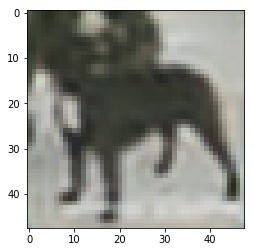

In [18]:
test_dataset = DenoisingDataset('data', 
                                train=False,
                                transform=transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                ]))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
decoded_samples = []
autoencoder.eval()
for step, x in enumerate(test_loader): 
    _,de_x = autoencoder(x)
    decoded_samples.append(de_x.detach().numpy())
    
sampled_z = np.concatenate(decoded_samples, axis=0)


def save_result(images: np.ndarray, out_path: str):
    assert images.shape == (400, 3, 48, 48)
    flat_img = images.reshape(400, -1)
    n_rows = np.prod(images.shape)
    
    y_with_id = np.concatenate([np.arange(n_rows).reshape(-1, 1), flat_img.reshape(n_rows, 1)], axis=1)
    np.savetxt(out_path, y_with_id, delimiter=",", fmt=['%d', '%.4f'], header="id,expetced", comments='')
    
save_result(sampled_z, 'solution.csv')
show_img(x[0].squeeze(0))
show_img(de_x[0].data.squeeze(0))
